## Import the needed `Libraries`

In [ ]:
import matplotlib.pyplot as plt
from typing import Tuple
import seaborn as sns
import numpy as np
import cv2


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers,models
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
from tensorflow import keras

## Load the `MNIST degit` data from `keras`

In [ ]:
def load_mnist():
    """
    Load the MNIST dataset.

    Returns:
        Tuple of NumPy arrays : (x_train_full, y_train_full, x_test, y_test)
    """
    (x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()
    return x_train_full, y_train_full, x_test, y_test

# Separate the train/test data
x_train_full, y_train_full, x_test, y_test = load_mnist()

# Print the length of the loaded data
print(f"Number of training samples: {len(x_train_full)}")
print(f"Number of testing samples: {len(x_test)}")

11490434/11490434 [==============================] - 0s 0us/step
Number of training samples: 60000
Number of testing samples: 10000


We're using a dataset of **60,000 images** to train a semi-supervised model. Out of these, **100 images are labeled**, and the remaining **59,900 are unlabeled**. After training, we'll assess the model's performance on **10,000 test images**.

> **Note:** The 100 labeled images might not be sufficient (we'll explain later). To address this, we'll employ `data augmentation` on the labeled set. Afterward, we'll retrain the model and compare performances. Simultaneously, we'll experiment with **different models** to identify which one learns the most from our data.

## Selecting `Train/Test Data` with Respect to Data Balance

In [ ]:
def get_class_indices(y, class_label, count):
    """
    Get random indices for a specific class.

    Args:
        y (np.ndarray): Labels.
        class_label (int): Class label.
        count (int): Number of indices to select.

    Returns:
        NumPy array of indices.
    """
    class_indices = np.where(y == class_label)[0]
    return np.random.choice(class_indices, size=count, replace=False)

In [ ]:
def select_labeled_and_unlabeled_data_with_validation(x_train_full, y_train_full, labeled_count_per_class, validation_count, test_unlabeled_count):
    """
    Select a small subset for labeled data, use the rest as unlabeled,
    and select a fixed number of samples for validation and unlabeled for testing.

    Args:
        x_train_full (np.ndarray): Full set of input images.
        y_train_full (np.ndarray): Full set of labels.
        labeled_count_per_class (int): Number of labeled examples per class.
        validation_count (int): Number of samples for the validation set.
        test_unlabeled_count (int): Number of samples for the unlabeled test set.

    Returns:
        Tuple of NumPy arrays: (x_labeled, y_labeled, x_unlabeled, x_validation, y_validation)
    """
    # Get unique classes in the training set
    classes = np.unique(y_train_full)

    # Select a small subset for labeled data
    labeled_indices = np.concatenate([get_class_indices(y_train_full, label, labeled_count_per_class) for label in classes])
    x_labeled = x_train_full[labeled_indices]
    y_labeled = y_train_full[labeled_indices]

    # Use the rest of the data as unlabeled
    x_unlabeled = np.delete(x_train_full, labeled_indices, axis=0)
    y_unlabeled = np.delete(y_train_full, labeled_indices, axis=0)

    # Use StratifiedShuffleSplit to split the remaining data into training and validation sets
    sss = StratifiedShuffleSplit(n_splits=1, test_size=validation_count, random_state=42)

    for train_index, validation_index in sss.split(x_unlabeled, y_unlabeled):
        x_validation = x_unlabeled[validation_index]
        y_validation = y_unlabeled[validation_index]
        x_unlabeled = x_unlabeled[train_index]
        y_unlabeled = y_unlabeled[train_index]

    # Take the remaining samples as unlabeled for testing
    x_unlabeled_test = x_unlabeled[:test_unlabeled_count]
    y_unlabeled_test = y_unlabeled[:test_unlabeled_count]

    # Shuffle x_labeled, x_validation, and x_unlabeled in the same way
    shuffle_indices = np.random.permutation(len(x_labeled))
    x_labeled = x_labeled[shuffle_indices]
    y_labeled = y_labeled[shuffle_indices]

    shuffle_indices = np.random.permutation(len(x_validation))
    x_validation = x_validation[shuffle_indices]
    y_validation = y_validation[shuffle_indices]

    shuffle_indices = np.random.permutation(len(x_unlabeled))
    x_unlabeled = x_unlabeled[shuffle_indices]
    y_unlabeled_test = y_unlabeled_test[shuffle_indices]

    return x_labeled, y_labeled, x_unlabeled, x_validation, y_validation

# Example of using the function
x_labeled, y_labeled, x_unlabeled, x_validation, y_validation = select_labeled_and_unlabeled_data_with_validation(
    x_train_full, y_train_full, labeled_count_per_class=10, validation_count=100, test_unlabeled_count=59800
)

# Print information about labeled, unlabeled, and validation sets
print(f"Number of labeled samples in the train set: {len(x_labeled)}")
print(f"Number of unique classes in labeled data: {len(np.unique(y_labeled))}")
for class_label in np.unique(y_labeled):
    class_count = np.sum(y_labeled == class_label)
    print(f"-> Number of samples for class {class_label}: {class_count}")

print(f"Number of unlabeled samples in the test set: {len(x_unlabeled)}")

print(f"\nNumber of samples in the validation set: {len(x_validation)}")
print(f"Number of unique classes in the validation set: {len(np.unique(y_validation))}")
for class_label in np.unique(y_validation):
    class_count = np.sum(y_validation == class_label)
    print(f"-> Number of samples for class {class_label}: {class_count}")

Number of labeled samples in the train set: 100
Number of unique classes in labeled data: 10
-> Number of samples for class 0: 10
-> Number of samples for class 1: 10
-> Number of samples for class 2: 10
-> Number of samples for class 3: 10
-> Number of samples for class 4: 10
-> Number of samples for class 5: 10
-> Number of samples for class 6: 10
-> Number of samples for class 7: 10
-> Number of samples for class 8: 10
-> Number of samples for class 9: 10
Number of unlabeled samples in the test set: 59800

Number of samples in the validation set: 100
Number of unique classes in the validation set: 10
-> Number of samples for class 0: 10
-> Number of samples for class 1: 11
-> Number of samples for class 2: 10
-> Number of samples for class 3: 10
-> Number of samples for class 4: 10
-> Number of samples for class 5: 9
-> Number of samples for class 6: 10
-> Number of samples for class 7: 10
-> Number of samples for class 8: 10
-> Number of samples for class 9: 10


> **Note:** We kept the `data balanced` in the **target column** by randomly picking 100 images, 10 from each class.

## `Exploring the Data`: Visualizing 10 Random Samples from the Training Dataset

Image 1, Label: 1
Image 2, Label: 0
Image 3, Label: 6
Image 4, Label: 9
Image 5, Label: 3
Image 6, Label: 0
Image 7, Label: 8
Image 8, Label: 2
Image 9, Label: 1
Image 10, Label: 5


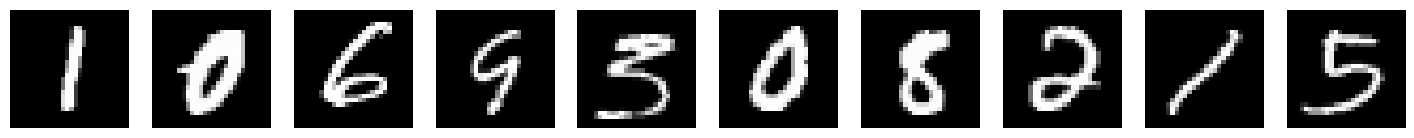

In [ ]:
def display_random_images(x_data, y_data, num_images=10):
    # Generate random indices
    random_indices = np.random.choice(len(x_data), num_images, replace=False)

    # Create subplots
    fig, axs = plt.subplots(1, num_images, figsize=(18, 2))

    for i, index in enumerate(random_indices):
        # Print the label
        print(f"Image {i + 1}, Label:", y_data[index])

        # Reshape the image and display it
        img = x_data[index].reshape(28, 28)
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')  # Turn off axis for cleaner display

    # Display the plot
    plt.show()

# Assuming y_labeled and x_labeled are defined somewhere before calling the function
display_random_images(x_validation, y_validation, num_images=10)

Here, we **displayed 10 randomly** selected images from the training set with the aim of **visually understanding the nature of the data**.

# `Normalize` the data

In [ ]:
def normalize_data_with_validation(x_labeled,
                                   x_unlabeled,
                                   x_validation,
                                   x_test):
    """
    Normalize pixel values of input images to the range [0, 1].

    Args:
        x_labeled (np.ndarray): Labeled input images.
        x_unlabeled (np.ndarray): Unlabeled input images.
        x_validation (np.ndarray): Validation input images.
        x_test (np.ndarray): Test input images.

    Returns:
        Tuple of normalized NumPy arrays: (x_labeled, x_unlabeled, x_validation, x_test)
    """
    x_labeled = x_labeled / 255.0
    x_unlabeled = x_unlabeled / 255.0
    x_validation = x_validation / 255.0
    x_test = x_test / 255.0

    return x_labeled, x_unlabeled, x_validation, x_test

# Normalize the pixel values of the images to the range [0, 1], including validation set
x_labeled, x_unlabeled, x_validation, x_test = normalize_data_with_validation(
    x_labeled, x_unlabeled, x_validation, x_test
)

This code **normalizes** MNIST digits data by scaling pixel values to the range [0, 1], `aiding faster model training and ensuring consistency`.

-----
# `Semi-Supervised` self-training CNN

### Defining the `Models` and Setting Up the Data

In [ ]:
model_CNN = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),  # Convolutional layer with 32 filters
    layers.MaxPooling2D((2, 2)),                                            # Max pooling layer
    layers.Flatten(),                                                       # Flatten for fully connected layers
    layers.Dense(128, activation='relu'),                                   # Fully connected layer with 128 units and ReLU activation
    layers.Dense(10, activation='softmax')                                  # Output layer with 10 units and softmax activation
])

# Display the model summary
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 128)               692352    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 693962 (2.65 MB)
Trainable params: 693962 (2.65 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

### `Training` and `Testing` the Model

In [ ]:
def pseudo_labeling(model, x_unlabeled, confidence_threshold=0.8):
    """
    Perform pseudo-labeling on unlabeled data using the given model.

    Parameters:
        model: Trained model for pseudo-labeling.
        x_unlabeled: Unlabeled input images.
        confidence_threshold: Confidence threshold for pseudo-labeling.

    Returns:
        Tuple of numpy arrays: (pseudo_labeled_images, pseudo_labels, x_unlabeled_unused)
    """
    # Predict pseudo-labels for the unlabeled data using the provided model
    pseudo_labels = model.predict(x_unlabeled)

    # Create a mask to identify instances with confidence above the threshold
    confident_mask = np.max(pseudo_labels, axis=1) > confidence_threshold

    # Check if there are instances with confidence above the threshold
    num_confident_instances = np.sum(confident_mask)
    total_instances = len(x_unlabeled)
    print(f"\n\nNumber of instances with confidence > {confidence_threshold}: {num_confident_instances} out of {total_instances}\n\n")

    # Check if there are instances with confidence above the threshold
    if num_confident_instances > 0:
        # Extract pseudo-labeled images and their corresponding labels
        pseudo_labeled_images = x_unlabeled[confident_mask]
        pseudo_labels = np.argmax(pseudo_labels[confident_mask], axis=1)

        # Extract unused unlabeled images
        x_unlabeled_unused = x_unlabeled[~confident_mask]

        return pseudo_labeled_images, pseudo_labels, x_unlabeled_unused
    else:
        # Return None if no instances meet the confidence threshold
        return None, None, x_unlabeled

In [ ]:
# Selecting the model and hyperparameters
classifier1, classifier2 = model_CNN, model_CNN
epochs_classifier1, batch_size_classifier1= 150, 32
epochs_classifier2, batch_size_classifier2= 100, 2000

# Compile the classifier1 and classifier2
classifier1.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Use EarlyStopping to avoid wasting time
early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)

# Learning rate schedule
def lr_schedule(epoch):
    return 0.001 * 0.9**epoch

lr_scheduler = LearningRateScheduler(lr_schedule)


# Print the number of elements used to train the first classifier
print(f">>>> Number of elements used to train the first classifier: {len(x_labeled)}")

# Train the model with the original labeled data and validation set, and save the history
history_classifier1 = classifier1.fit(
    x_labeled,
    y_labeled,
    epochs=epochs_classifier1,
    batch_size=batch_size_classifier1,
    validation_data=(x_validation, y_validation),
    callbacks=[early_stop, lr_scheduler]
)

# Pseudo-labeling
pseudo_labeled_images, pseudo_labels, x_unlabeled_unused = pseudo_labeling(classifier1,
                                                                           x_unlabeled,
                                                                           confidence_threshold=0.95)

if pseudo_labeled_images is not None:
    # Update labeled data with pseudo-labeled data
    x_labeled_and_pseudo_labeled_images = np.concatenate([x_labeled, pseudo_labeled_images])
    y_labeled_and_pseudo_labeled_images = np.concatenate([y_labeled, pseudo_labels])

    # Print the number of elements used to train the first classifier and pseudo-labeled data
    print(f">>>> Number of elements used to train the second classifier : {len(x_labeled_and_pseudo_labeled_images)+len(x_unlabeled_unused)}")

    # Train the classifier2 on the full dataset (original + pseudo-labeled) with validation set, and save the history
    history_classifier2 = classifier2.fit(
        np.concatenate([x_labeled_and_pseudo_labeled_images, x_unlabeled_unused]),
        np.concatenate([y_labeled_and_pseudo_labeled_images, np.argmax(classifier2.predict(x_unlabeled_unused), axis=1)]),
        epochs=epochs_classifier2,
        batch_size=batch_size_classifier2,
        validation_data=(x_validation, y_validation),
        callbacks=[early_stop, lr_scheduler]
    )

# Evaluate the classifier2 Performance on Test Data
test_loss, test_acc = classifier2.evaluate(x_test, y_test)
print(f"classifier2 - Test Loss: {test_loss}, Test Accuracy: {test_acc}\n")

>>>> Number of elements used to train the first classifier: 100
Epoch 1/150
4/4 [==============================] - 15s 88ms/step - loss: 2.2288 - accuracy: 0.2100 - val_loss: 1.9703 - val_accuracy: 0.5900 - lr: 0.0010
Epoch 2/150
4/4 [==============================] - 0s 18ms/step - loss: 1.7661 - accuracy: 0.7400 - val_loss: 1.6779 - val_accuracy: 0.6100 - lr: 9.0000e-04
Epoch 3/150
4/4 [==============================] - 0s 17ms/step - loss: 1.3890 - accuracy: 0.8200 - val_loss: 1.4463 - val_accuracy: 0.6800 - lr: 8.1000e-04
Epoch 4/150
4/4 [==============================] - 0s 14ms/step - loss: 1.0897 - accuracy: 0.8400 - val_loss: 1.2494 - val_accuracy: 0.6700 - lr: 7.2900e-04
Epoch 5/150
4/4 [==============================] - 0s 18ms/step - loss: 0.8276 - accuracy: 0.8800 - val_loss: 1.1284 - val_accuracy: 0.6800 - lr: 6.5610e-04
Epoch 6/150
4/4 [==============================] - 0s 17ms/step - loss: 0.6509 - accuracy: 0.9300 - val_loss: 1.0206 - val_accuracy: 0.6700 - lr: 5.9049e-

In [ ]:
def plot_and_print_classification_metrics(y_true, y_pred):
    # Create a confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(10), yticklabels=np.arange(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Classification report
    class_report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(10)])
    print("Classification Report:\n", class_report)

313/313 [==============================] - 1s 2ms/step


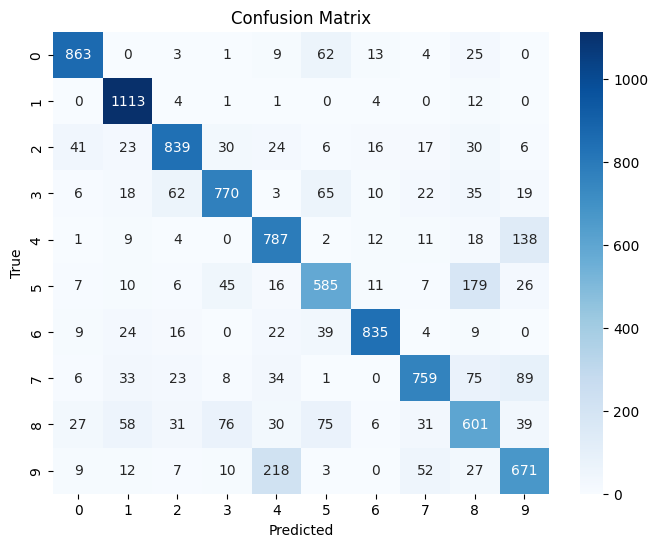

Test Accuracy: 0.7823
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.89       980
           1       0.86      0.98      0.91      1135
           2       0.84      0.81      0.83      1032
           3       0.82      0.76      0.79      1010
           4       0.69      0.80      0.74       982
           5       0.70      0.66      0.68       892
           6       0.92      0.87      0.90       958
           7       0.84      0.74      0.78      1028
           8       0.59      0.62      0.61       974
           9       0.68      0.67      0.67      1009

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



In [ ]:
# Predictions on the test set using classifier2
y_pred = np.argmax(classifier2.predict(x_test), axis=1)

# Use the function to plot and print metrics
plot_and_print_classification_metrics(y_test, y_pred)

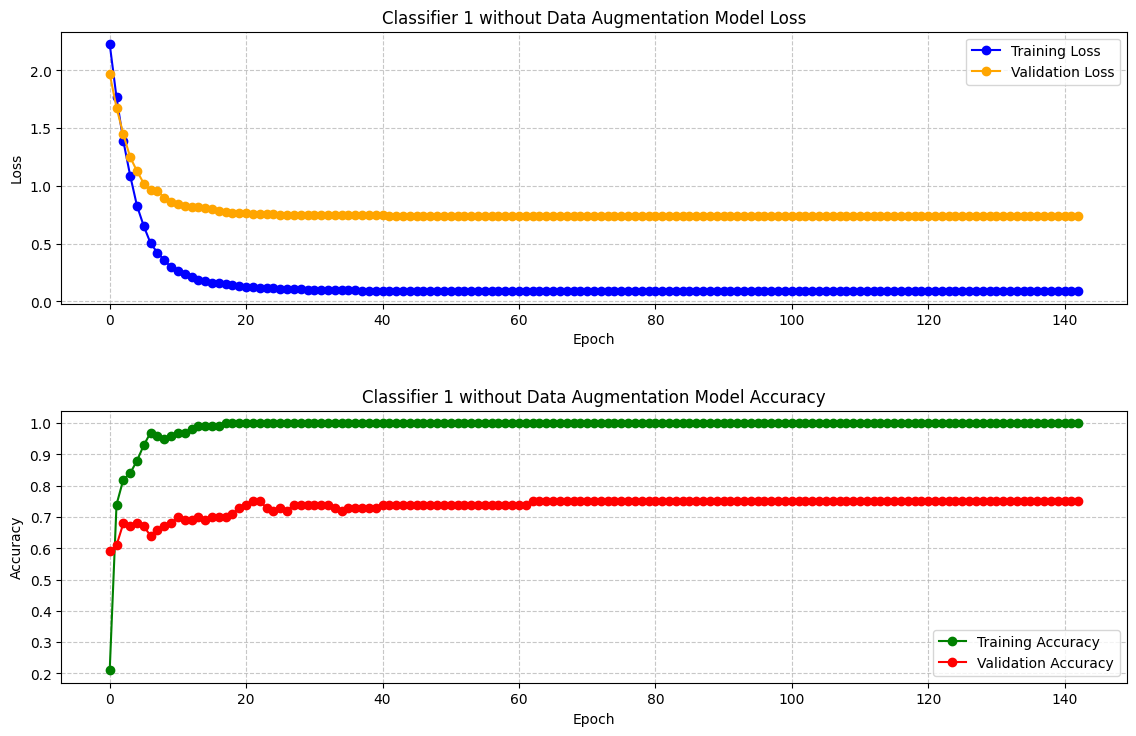

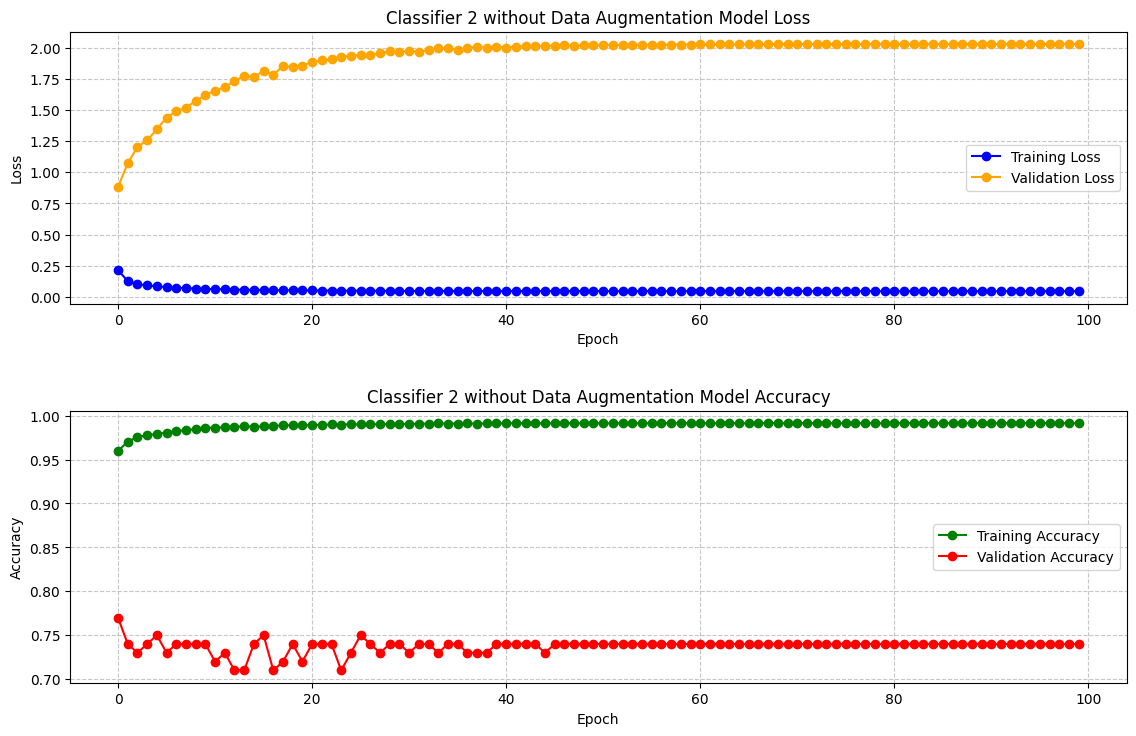

In [ ]:
# Plot the training loss and validation accuracy for both classifiers with improved aesthetics
def plot_metrics(history, title):
    plt.figure(figsize=(12, 8))

    # Plot training and validation loss
    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', marker='o')
    plt.title(f'{title} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot training and validation accuracy
    plt.subplot(2, 1, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='green', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', marker='o')
    plt.title(f'{title} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout(pad=3.0)
    plt.show()

# Plot the training loss and validation accuracy for each classifier
plot_metrics(history_classifier1, 'Classifier 1 without Data Augmentation')
plot_metrics(history_classifier2, 'Classifier 2 without Data Augmentation')

### `Testing` the Model on a Random MNIST Image

1/1 [==============================] - 0s 39ms/step


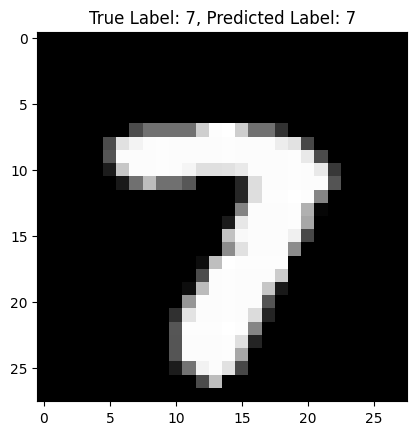

1/1 [==============================] - 0s 17ms/step


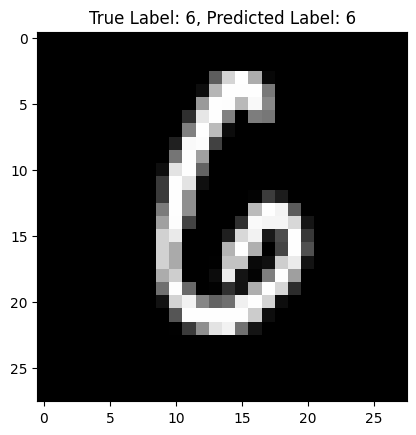

1/1 [==============================] - 0s 17ms/step


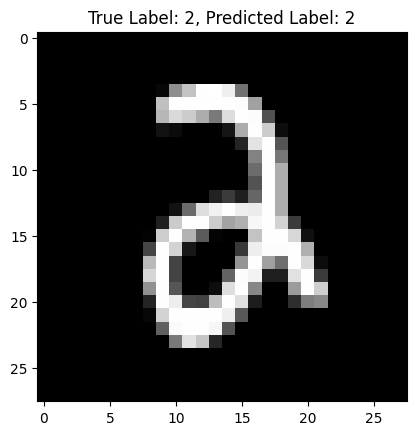

1/1 [==============================] - 0s 19ms/step


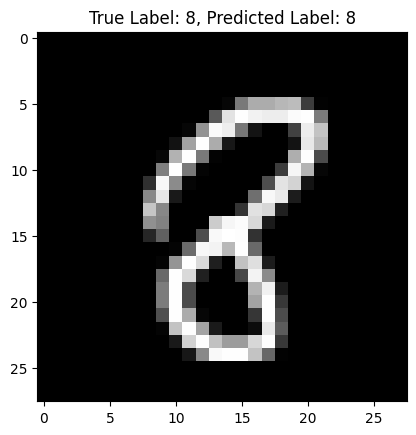

1/1 [==============================] - 0s 20ms/step


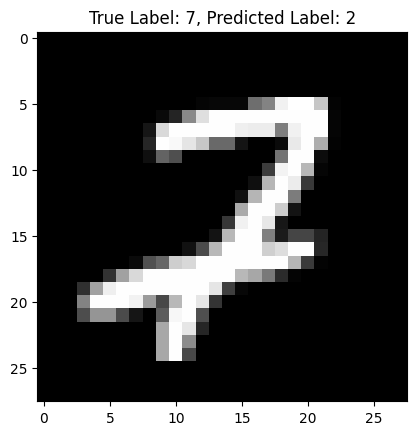

In [ ]:
def visualize_predictions(model, x_test, y_test, num_samples):
    """
    Visualize predictions on a few test images.

    Args:
        model (keras.Model): Trained neural network model.
        x_test (np.ndarray): Test input images.
        y_test (np.ndarray): Test labels.
        num_samples (int): Number of test samples to visualize. Default is 5.
    """
    # Randomly select test samples
    test_indices = np.random.choice(range(len(x_test)), size=num_samples, replace=False)

    # Iterate over selected test samples
    for index in test_indices:
        test_image = x_test[index].reshape(1, 28, 28)  # Reshape for prediction
        prediction = model.predict(test_image)

        # Display the test image along with true and predicted labels
        plt.figure()
        plt.imshow(test_image.squeeze(), cmap='gray')
        plt.title(f"True Label: {y_test[index]}, Predicted Label: {np.argmax(prediction)}")
        plt.show()

num_samples = 5
visualize_predictions(classifier2, x_test, y_test, num_samples)

# Data `Augmentation`

#### Data `Augmentation` function for an image

In [ ]:
def augment_data(image, augment_factor=8):
    """
    Apply diverse data augmentation to a given image.

    Parameters:
        image (numpy.ndarray): Input image to be augmented.
        augment_factor (int): Number of augmented images to generate.

    Returns:
        numpy.ndarray: Array of augmented images.
    """
    augmented_images = []
    for _ in range(augment_factor):
        # Random rotation (between -10 and 10 degrees)
        angle = np.random.uniform(-10, 10)
        # Random translation (between -3 and 3 pixels in both x and y directions)
        tx = np.random.uniform(-3, 3)
        ty = np.random.uniform(-3, 3)
        # Random zoom (between 0.9 and 1.1)
        zoom = np.random.uniform(0.9, 1.1)
        # Random brightness adjustment
        brightness_factor = np.random.uniform(0.7, 1.3)
        # Random contrast adjustment
        contrast_factor = np.random.uniform(0.7, 1.3)
        # Apply transformations
        transform_matrix = cv2.getRotationMatrix2D((14, 14), angle, zoom)
        transform_matrix[:, 2] += (tx, ty)
        augmented_image = cv2.warpAffine(image[0], transform_matrix, (28, 28), flags=cv2.INTER_LINEAR)
        # Adjust brightness and contrast
        augmented_image = cv2.convertScaleAbs(augmented_image, alpha=brightness_factor, beta=contrast_factor)
        augmented_images.append(augmented_image.reshape(1, 28, 28, 1))
    augmented_images = np.vstack(augmented_images)
    return augmented_images

# Utility function to test the Data Augmentation on sample images
def visualize_images(images, title, labels):
    """
    Display images with their corresponding labels.

    Parameters:
        images (List[numpy.ndarray]): List of images to be visualized.
        title (str): Title for the visualization.
        labels (numpy.ndarray): Array of labels corresponding to the images.
    """
    plt.figure(figsize=(12, 3))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

## Testing `Data Augmentation` on a random MNIST image

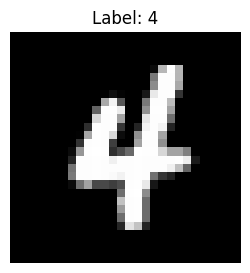

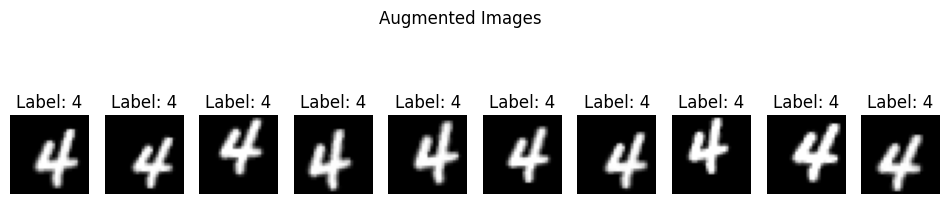

In [ ]:
# Select one image for demonstration
demo_index = np.random.choice(range(len(x_train_full)), size=1, replace=False)
demo_image = x_train_full[demo_index]
demo_label = y_train_full[demo_index]

# Display original image
visualize_images([demo_image], "", demo_label)

# Data augmentation for demonstration
augmented_images = augment_data(demo_image, augment_factor=10)

# Display augmented images
augmented_labels = np.full(len(augmented_images), demo_label[0])
visualize_images(augmented_images, "Augmented Images", augmented_labels)

-----

# Semi-Supervised self-training CNN with `Data Augmentation`
### Applying `Data Augmentation` on `Labeled Images`

In [ ]:
# Function to generate augmented labeled data
def augment_labeled_data(x, y, augmentation_factor):
    """
    Apply data augmentation to labeled data.

    Parameters:
        x (numpy.ndarray): Labeled input images.
        y (numpy.ndarray): Corresponding labels.
        augmentation_factor (int): Number of augmented images to generate for each labeled image.

    Returns:
        (numpy.ndarray, numpy.ndarray): Tuple of augmented labeled images and their corresponding labels.
    """
    augmented_labeled_images = []
    augmented_labels = []

    for i in range(len(x)):
        augmented_images = augment_data(x[i:i+1], augmentation_factor)
        augmented_labeled_images.append(augmented_images)
        augmented_labels.extend([y[i]] * augmentation_factor)

    # Reshape augmented images to match the dimensions of x
    augmented_labeled_images = np.vstack(augmented_labeled_images).reshape(-1, 28, 28)

    return augmented_labeled_images, np.array(augmented_labels)

# Data Augmentation
augmentation_factor = 150
augmented_x_labeled, augmented_y_labeled = augment_labeled_data(x=x_labeled,
                                                                y=y_labeled,
                                                                augmentation_factor=augmentation_factor)

In [ ]:
# Create the full training data after we have done the data augmentation
full_x_labeled = np.concatenate([x_labeled, augmented_x_labeled])
full_y_labeled = np.concatenate([y_labeled, augmented_y_labeled])

# Shuffle full_x_labeled and full_y_labeled in the same way
shuffle_indices = np.random.permutation(len(augmented_x_labeled))
full_x_labeled = full_x_labeled[shuffle_indices]
full_y_labeled = full_y_labeled[shuffle_indices]

# Print details about the data used for training
print(f"Number of original labeled samples: {len(x_labeled)}")
print(f"Number of augmented samples per original labeled sample: {augmentation_factor}")
print(f"Total number of labeled samples after augmentation: {len(full_x_labeled)}")

# Print details about the unlabeled data
print(f"Number of unlabeled samples: {len(x_unlabeled)}")

Number of original labeled samples: 100
Number of augmented samples per original labeled sample: 150
Total number of labeled samples after augmentation: 15000
Number of unlabeled samples: 59800


Image 1, Label: 2
Image 2, Label: 9
Image 3, Label: 1
Image 4, Label: 2
Image 5, Label: 0
Image 6, Label: 6
Image 7, Label: 4
Image 8, Label: 1
Image 9, Label: 2
Image 10, Label: 7


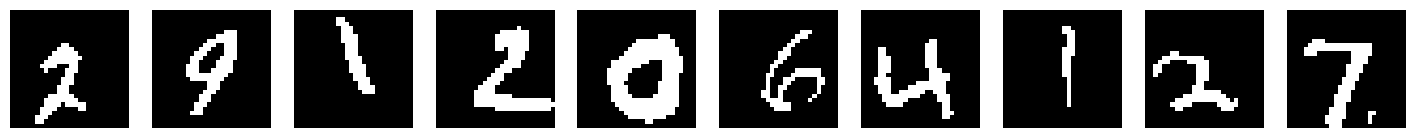

In [ ]:
display_random_images(full_x_labeled, full_y_labeled, num_images=10)

#### `Training` and `Testing` the Model

In [ ]:
# Selecting the model and hyperparameters
classifier1_augmented, classifier2_augmented = model_CNN, model_CNN
epochs_classifier1_augmented, batch_size_classifier1_augmented= 150, 32
epochs_classifier2_augmented, batch_size_classifier2_augmented= 100, 2000

# Compile the classifier1_augmented and classifier2_augmented
classifier1_augmented.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier2_augmented.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Use EarlyStopping to avoid wasting time
early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)

# Print the number of elements used to train the first classifier
print(f">>>> Number of elements used to train the first classifier: {len(full_x_labeled)}")

# Train the model with the original labeled data and validation set, and save the history
history_classifier1_augmented = classifier1_augmented.fit(
    full_x_labeled,  # x_labeled and augmented_x_labeled
    full_y_labeled,  # y_labeled and augmented_y_labeled
    epochs=epochs_classifier1_augmented,
    batch_size=batch_size_classifier1_augmented,
    validation_data=(x_validation, y_validation),
    callbacks=[early_stop, lr_scheduler]
)

# Pseudo-labeling
pseudo_labeled_images, pseudo_labels, x_unlabeled_unused = pseudo_labeling(classifier1_augmented,
                                                                           x_unlabeled,
                                                                           confidence_threshold=0.95)

if pseudo_labeled_images is not None:
    # Update labeled data with pseudo-labeled data
    x_labeled_and_pseudo_labeled_images = np.concatenate([full_x_labeled, pseudo_labeled_images])
    y_labeled_and_pseudo_labeled_images = np.concatenate([full_y_labeled, pseudo_labels])

    # Print the number of elements used to train the first classifier and pseudo-labeled data
    print(
        f">>>> Number of elements used to train the second classifier : {len(x_labeled_and_pseudo_labeled_images) + len(x_unlabeled_unused)} ( number of augmented elements: {len(augmented_x_labeled)} )")

    # Train the classifier2 on the full dataset (original + pseudo-labeled) with validation set, and save the history
    history_classifier2_augmented = classifier2_augmented.fit(
        np.concatenate([x_labeled_and_pseudo_labeled_images, x_unlabeled_unused]),
        np.concatenate([y_labeled_and_pseudo_labeled_images,
                        np.argmax(classifier2_augmented.predict(x_unlabeled_unused), axis=1)]),
        epochs=epochs_classifier2_augmented,
        batch_size=batch_size_classifier2_augmented,
        validation_data=(x_validation, y_validation),
        callbacks=[early_stop, lr_scheduler]
    )

# Evaluate the classifier2 Performance on Test Data
test_loss, test_acc = classifier2_augmented.evaluate(x_test, y_test)
print(f"classifier2 - Test Loss: {test_loss}, Test Accuracy: {test_acc}\n")

>>>> Number of elements used to train the first classifier: 15000
Epoch 1/150
469/469 [==============================] - 3s 5ms/step - loss: 1.8528 - accuracy: 0.7059 - val_loss: 0.5277 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 2/150
469/469 [==============================] - 2s 4ms/step - loss: 0.3544 - accuracy: 0.8972 - val_loss: 0.4924 - val_accuracy: 0.8300 - lr: 9.0000e-04
Epoch 3/150
469/469 [==============================] - 2s 3ms/step - loss: 0.2337 - accuracy: 0.9331 - val_loss: 0.4087 - val_accuracy: 0.8700 - lr: 8.1000e-04
Epoch 4/150
469/469 [==============================] - 2s 3ms/step - loss: 0.1764 - accuracy: 0.9522 - val_loss: 0.3768 - val_accuracy: 0.8500 - lr: 7.2900e-04
Epoch 5/150
469/469 [==============================] - 2s 3ms/step - loss: 0.1399 - accuracy: 0.9618 - val_loss: 0.3985 - val_accuracy: 0.8600 - lr: 6.5610e-04
Epoch 6/150
469/469 [==============================] - 2s 3ms/step - loss: 0.1172 - accuracy: 0.9669 - val_loss: 0.4585 - val_accuracy: 0.

313/313 [==============================] - 1s 2ms/step


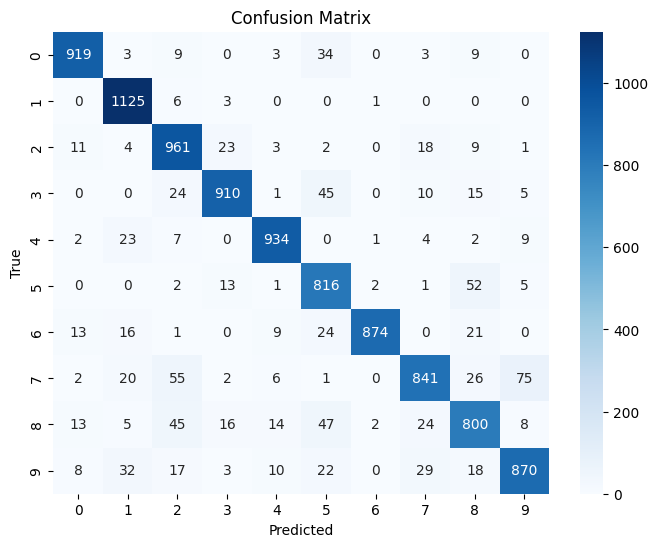

Test Accuracy: 0.9050
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94       980
           1       0.92      0.99      0.95      1135
           2       0.85      0.93      0.89      1032
           3       0.94      0.90      0.92      1010
           4       0.95      0.95      0.95       982
           5       0.82      0.91      0.87       892
           6       0.99      0.91      0.95       958
           7       0.90      0.82      0.86      1028
           8       0.84      0.82      0.83       974
           9       0.89      0.86      0.88      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.91      0.90     10000



In [ ]:
# Predictions on the test set using classifier2
y_pred_augmented = np.argmax(classifier2_augmented.predict(x_test), axis=1)

# Use the function to plot and print metrics
plot_and_print_classification_metrics(y_test, y_pred_augmented)

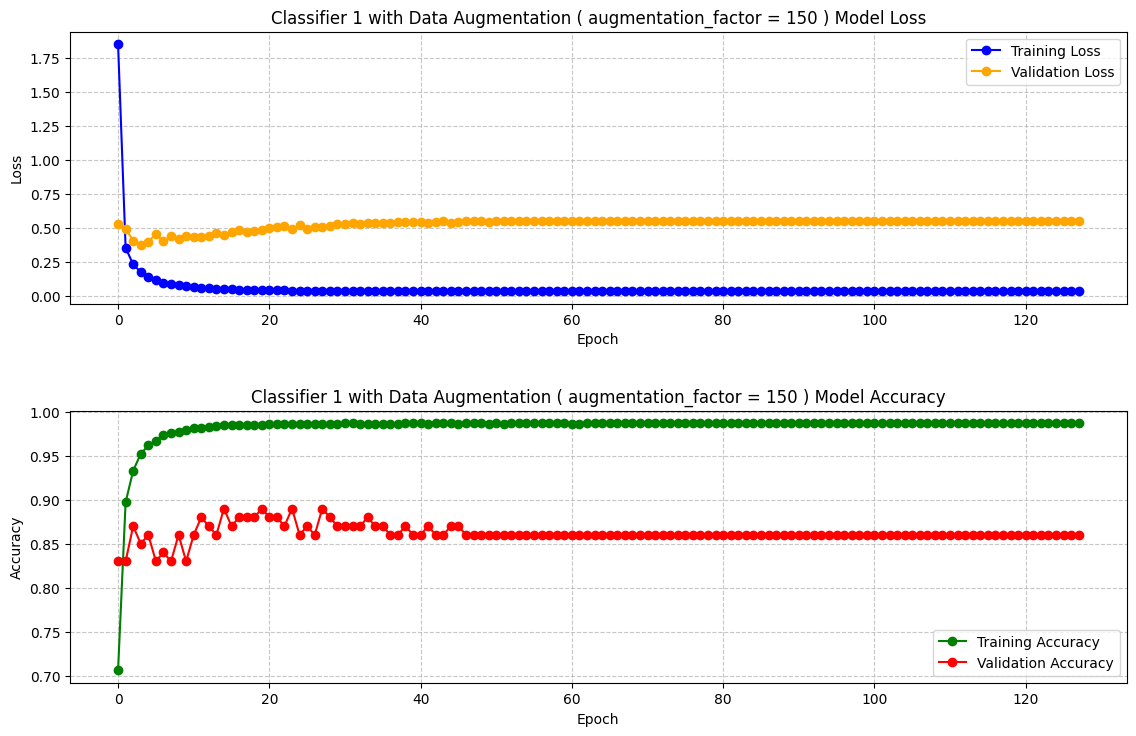

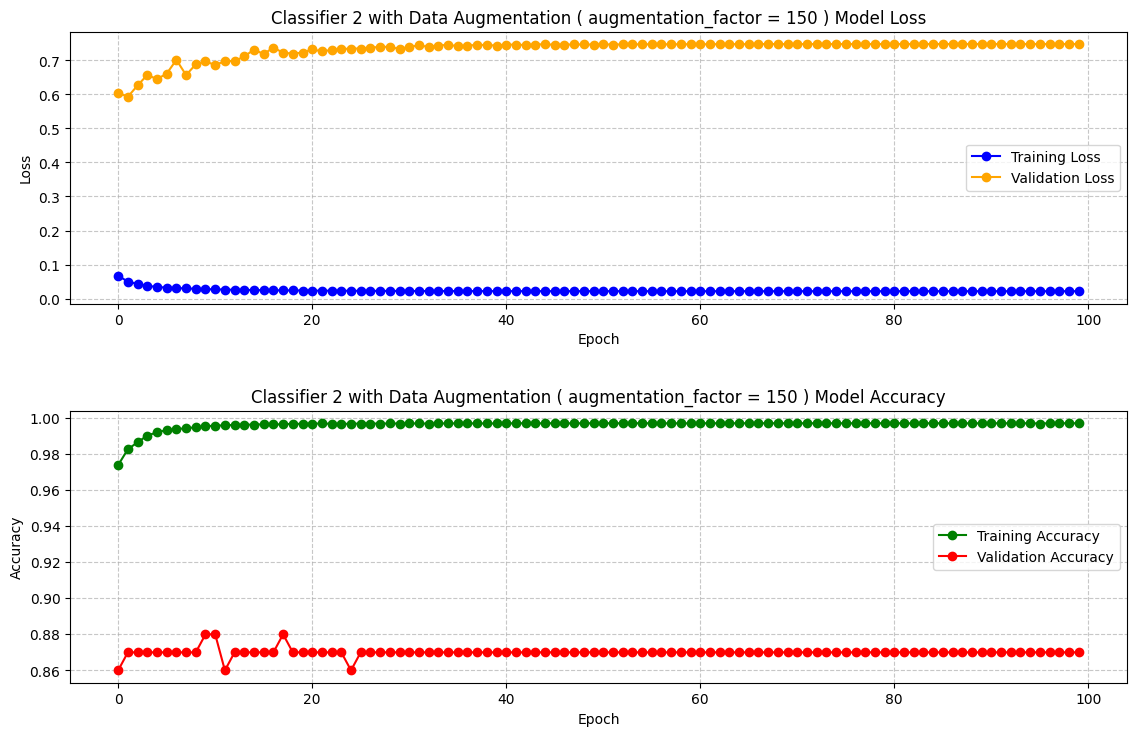

In [ ]:
# Plot the training loss and validation accuracy for each classifier with data augmentation
plot_metrics(history_classifier1_augmented, f'Classifier 1 with Data Augmentation ( augmentation_factor = {augmentation_factor} )')
plot_metrics(history_classifier2_augmented, f'Classifier 2 with Data Augmentation ( augmentation_factor = {augmentation_factor} )')

#### Testing the Model on an MNIST Image




1/1 [==============================] - 0s 21ms/step


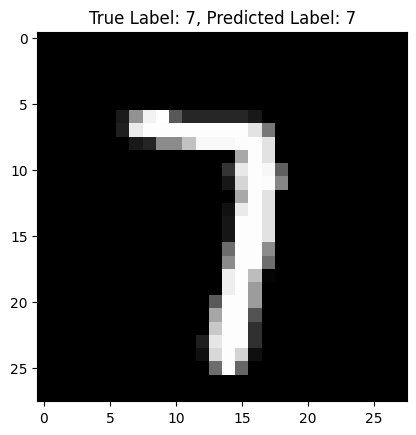

1/1 [==============================] - 0s 20ms/step


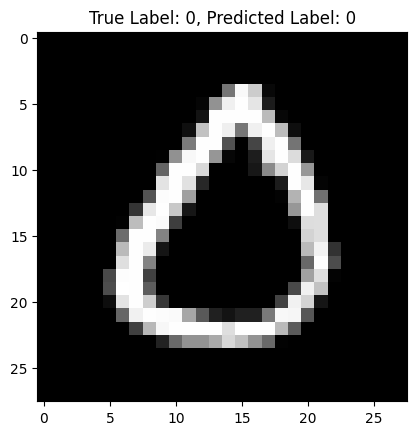

1/1 [==============================] - 0s 19ms/step


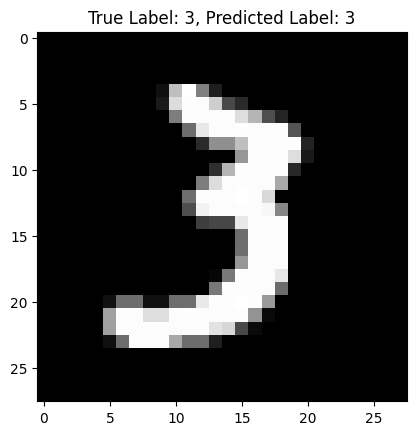

1/1 [==============================] - 0s 18ms/step


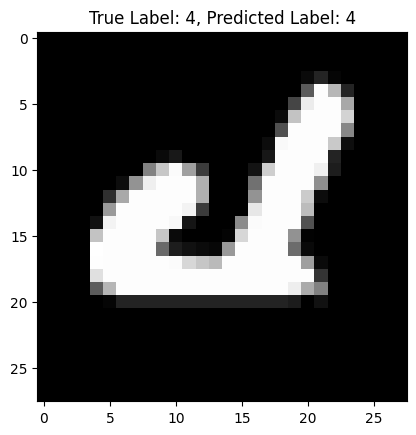

1/1 [==============================] - 0s 20ms/step


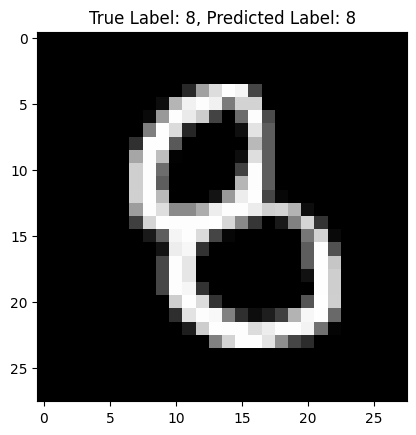

In [ ]:
num_samples = 5
visualize_predictions(classifier2_augmented, x_test, y_test, num_samples)

----

#### Data `Augmentation` function for an image with added `Gaussian noise`

In [ ]:
def augment_data_with_noise(image, augment_factor, noise_factor):
    """
    Apply diverse data augmentation, including random noise, to a given image.

    Parameters:
        image (numpy.ndarray): Input image to be augmented.
        augment_factor (int, optional): Number of augmented images to generate. Defaults to 8.
        noise_factor (float, optional): Intensity of random noise to be added. Defaults to 0.1.

    Returns:
        numpy.ndarray: Array of augmented images.
    """
    augmented_images = []

    # Convert the image to float32 to allow for addition with floating-point noise
    image_float = image.astype(np.float32)

    for _ in range(augment_factor):
        # Random rotation (between -10 and 10 degrees)
        angle = np.random.uniform(-10, 10)
        # Random translation (between -3 and 3 pixels in both x and y directions)
        tx = np.random.uniform(-3, 3)
        ty = np.random.uniform(-3, 3)
        # Random zoom (between 0.9 and 1.1)
        zoom = np.random.uniform(0.9, 1.1)
        # Random brightness adjustment
        brightness_factor = np.random.uniform(0.7, 1.3)
        # Random contrast adjustment
        contrast_factor = np.random.uniform(0.7, 1.3)

        # Apply transformations
        transform_matrix = cv2.getRotationMatrix2D((14, 14), angle, zoom)
        transform_matrix[:, 2] += (tx, ty)
        augmented_image = cv2.warpAffine(image[0], transform_matrix, (28, 28), flags=cv2.INTER_LINEAR)

        # Adjust brightness and contrast
        augmented_image = cv2.convertScaleAbs(augmented_image, alpha=brightness_factor, beta=contrast_factor)

        # Add random noise
        noise = np.random.normal(scale=noise_factor, size=augmented_image.shape).astype(np.float32)
        augmented_image = image_float + noise

        # Clip the values to the valid uint8 range [0, 255]
        augmented_image = np.clip(augmented_image, 0, 255).astype(np.uint8)

        augmented_images.append(augmented_image.reshape(1, 28, 28, 1))

    augmented_images = np.vstack(augmented_images)
    return augmented_images

#### Testing `Data Augmentation` with `Gaussian noise` on a random MNIST image

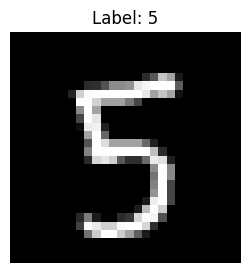

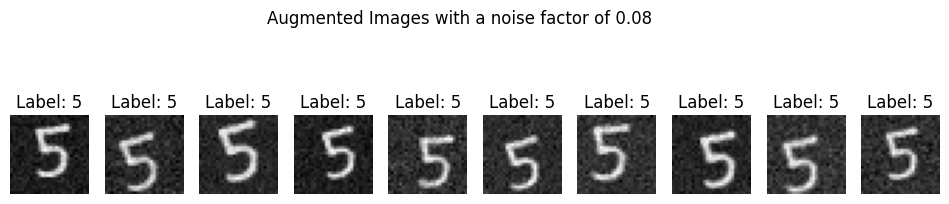

In [ ]:
# Select one image for demonstration
demo_index = np.random.choice(range(len(x_train_full)), size=1, replace=False)
demo_image = x_train_full[demo_index]
demo_label = y_train_full[demo_index]

# Display original image
visualize_images([demo_image], "", demo_label)

# Data augmentation for demonstration
augmented_images = augment_data_with_noise(demo_image, augment_factor=10, noise_factor=0.08)

# Display augmented images
noise_factor = 10
augmented_labels = np.full(len(augmented_images), demo_label[0])
visualize_images(augmented_images, f"Augmented Images with a noise factor of {noise_factor}", augmented_labels)

-----

# Semi-Supervised self-training with `Data Augmentation` with `Gaussian noise`
### Applying `Data Augmentation` with `Gaussian noise` on `Labeled Images`

In [ ]:
# Function to generate augmented labeled data with noise
def augment_labeled_data_with_noise(x, y, augmentation_factor, noise_factor):
    """
    Apply data augmentation with noise to labeled data.

    Parameters:
        x (numpy.ndarray): Labeled input images.
        y (numpy.ndarray): Corresponding labels.
        augmentation_factor (int): Number of augmented images to generate for each labeled image.
        noise_factor (float): Factor to control the amount of noise to be added.

    Returns:
        (numpy.ndarray, numpy.ndarray): Tuple of augmented labeled images with noise and their corresponding labels.
    """
    augmented_labeled_images = []
    augmented_labels = []

    for i in range(len(x)):
        augmented_images = augment_data_with_noise(x[i:i+1], augmentation_factor, noise_factor)
        augmented_labeled_images.append(augmented_images)
        augmented_labels.extend([y[i]] * augmentation_factor)

    # Reshape augmented images to match the dimensions of x
    augmented_labeled_images = np.vstack(augmented_labeled_images).reshape(-1, 28, 28)

    return augmented_labeled_images, np.array(augmented_labels)

# Data Augmentation with Noise
def augment_data_with_noise(image, augment_factor=8, noise_factor=0.1):
    """
    Apply diverse data augmentation with noise to a given image.

    Parameters:
        image (numpy.ndarray): Input image to be augmented.
        augment_factor (int): Number of augmented images to generate.
        noise_factor (float): Factor to control the amount of noise to be added.

    Returns:
        numpy.ndarray: Array of augmented images with noise.
    """
    augmented_images = []
    for _ in range(augment_factor):
        # Call the existing augment_data function for transformations
        transformed_images = augment_data(image, 1)
        # Add noise to the transformed images without clipping
        noisy_images = add_noise(transformed_images, noise_factor)
        augmented_images.append(noisy_images)

    augmented_images = np.vstack(augmented_images)
    return augmented_images

# Function to add noise to images
def add_noise(images, noise_factor=0.1):
    """
    Add random noise to a given set of images.

    Parameters:
        images (numpy.ndarray): Input images.
        noise_factor (float): Factor to control the amount of noise to be added.

    Returns:
        numpy.ndarray: Array of images with added noise.
    """
    noisy_images = images + noise_factor * np.random.normal(0, 1, images.shape)
    return noisy_images

# Usage example
augmentation_factor = 400
noise_factor = 0.08
augmented_x_labeled_with_noise, augmented_y_labeled_with_noise = augment_labeled_data_with_noise(x=x_labeled,
                                                                            y=y_labeled,
                                                                            augmentation_factor=augmentation_factor,
                                                                            noise_factor=noise_factor)

In [ ]:
# Create the full training data after we have done the data augmentation with noise
full_x_labeled_with_noise = np.concatenate([x_labeled, augmented_x_labeled_with_noise])
full_y_labeled_with_noise = np.concatenate([y_labeled, augmented_y_labeled_with_noise])

# Shuffle full_x_labeled_with_noise and full_y_labeled_with_noise in the same way
shuffle_indices = np.random.permutation(len(full_x_labeled_with_noise))
full_x_labeled_with_noise = full_x_labeled_with_noise[shuffle_indices]
full_y_labeled_with_noise = full_y_labeled_with_noise[shuffle_indices]

# Print details about the data used for training
print(f"Number of original labeled samples: {len(x_labeled)}")
print(f"Number of augmented samples per original labeled sample: {augmentation_factor}")
print(f"Total number of labeled samples after augmentation with noise: {len(full_x_labeled)}")

# Print details about the unlabeled data
print(f"Number of unlabeled samples: {len(x_unlabeled)}")

Number of original labeled samples: 100
Number of augmented samples per original labeled sample: 400
Total number of labeled samples after augmentation with noise: 15000
Number of unlabeled samples: 59800


Image 1, Label: 1
Image 2, Label: 2
Image 3, Label: 3
Image 4, Label: 9
Image 5, Label: 9
Image 6, Label: 9
Image 7, Label: 5
Image 8, Label: 1
Image 9, Label: 7
Image 10, Label: 9


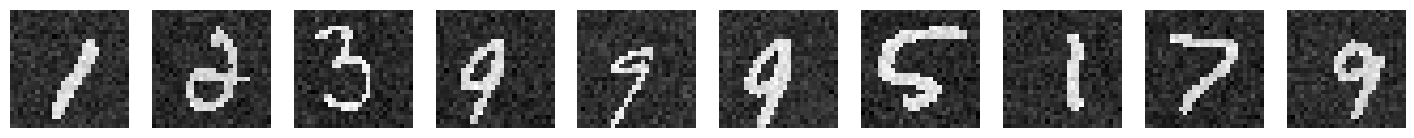

In [ ]:
display_random_images(full_x_labeled_with_noise, full_y_labeled_with_noise, num_images=10)

#### `Training` and `Testing` the Model

In [ ]:
# Selecting the model and hyperparameters
classifier1_augmented_with_noise, classifier2_augmented_with_noise = model_CNN, model_CNN
epochs_classifier1_augmented_with_noise, batch_size_classifier1_augmented_with_noise= 150, 32
epochs_classifier2_augmented_with_noise, batch_size_classifier2_augmented_with_noise= 100, 2000

# Compile the classifier1_augmented and classifier2_augmented
classifier1_augmented_with_noise.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier2_augmented_with_noise.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Use EarlyStopping to avoid wasting time
early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)

# Print the number of elements used to train the first classifier
print(f">>>> Number of elements used to train the first classifier: {len(full_x_labeled_with_noise)}")

# Train the model with the original labeled data and validation set, and save the history
history_classifier1_augmented_with_noise = classifier1_augmented.fit(
    full_x_labeled_with_noise,  # x_labeled and augmented_x_labeled_with_noise
    full_y_labeled_with_noise,  # y_labeled and augmented_y_labeled_with_noise
    epochs=epochs_classifier1_augmented_with_noise,
    batch_size=batch_size_classifier1_augmented_with_noise,
    validation_data=(x_validation, y_validation),
    callbacks=[early_stop, lr_scheduler]
)

# Pseudo-labeling
pseudo_labeled_images, pseudo_labels, x_unlabeled_unused = pseudo_labeling(classifier1_augmented_with_noise,
                                                                           x_unlabeled,
                                                                           confidence_threshold=0.95)

if pseudo_labeled_images is not None:
    # Update labeled data with pseudo-labeled data
    x_labeled_and_pseudo_labeled_images = np.concatenate([full_x_labeled, pseudo_labeled_images])
    y_labeled_and_pseudo_labeled_images = np.concatenate([full_y_labeled, pseudo_labels])

    # Print the number of elements used to train the first classifier and pseudo-labeled data
    print(
        f">>>> Number of elements used to train the second classifier : {len(x_labeled_and_pseudo_labeled_images) + len(x_unlabeled_unused)} ( number of augmented elements: {len(augmented_x_labeled)} )")

    # Train the classifier2 on the full dataset (original + pseudo-labeled) with validation set, and save the history
    history_classifier2_augmented_with_noise = classifier2_augmented_with_noise.fit(
        np.concatenate([x_labeled_and_pseudo_labeled_images, x_unlabeled_unused]),
        np.concatenate([y_labeled_and_pseudo_labeled_images,
                        np.argmax(classifier2_augmented_with_noise.predict(x_unlabeled_unused), axis=1)]),
        epochs=epochs_classifier2_augmented_with_noise,
        batch_size=batch_size_classifier2_augmented_with_noise,
        validation_data=(x_validation, y_validation),
        callbacks=[early_stop, lr_scheduler]
    )

# Evaluate the classifier2 Performance on Test Data
test_loss, test_acc = classifier2_augmented_with_noise.evaluate(x_test, y_test)
print(f"classifier2 - Test Loss: {test_loss}, Test Accuracy: {test_acc}\n")

>>>> Number of elements used to train the first classifier: 40100
Epoch 1/150
1254/1254 [==============================] - 6s 4ms/step - loss: 0.0999 - accuracy: 0.9658 - val_loss: 0.7596 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 2/150
1254/1254 [==============================] - 4s 3ms/step - loss: 0.0590 - accuracy: 0.9795 - val_loss: 0.6685 - val_accuracy: 0.8800 - lr: 9.0000e-04
Epoch 3/150
1254/1254 [==============================] - 4s 3ms/step - loss: 0.0483 - accuracy: 0.9829 - val_loss: 0.8639 - val_accuracy: 0.8500 - lr: 8.1000e-04
Epoch 4/150
1254/1254 [==============================] - 5s 4ms/step - loss: 0.0413 - accuracy: 0.9859 - val_loss: 0.8987 - val_accuracy: 0.8700 - lr: 7.2900e-04
Epoch 5/150
1254/1254 [==============================] - 4s 3ms/step - loss: 0.0374 - accuracy: 0.9876 - val_loss: 0.9046 - val_accuracy: 0.8900 - lr: 6.5610e-04
Epoch 6/150
1254/1254 [==============================] - 4s 4ms/step - loss: 0.0323 - accuracy: 0.9897 - val_loss: 0.9371 - val_

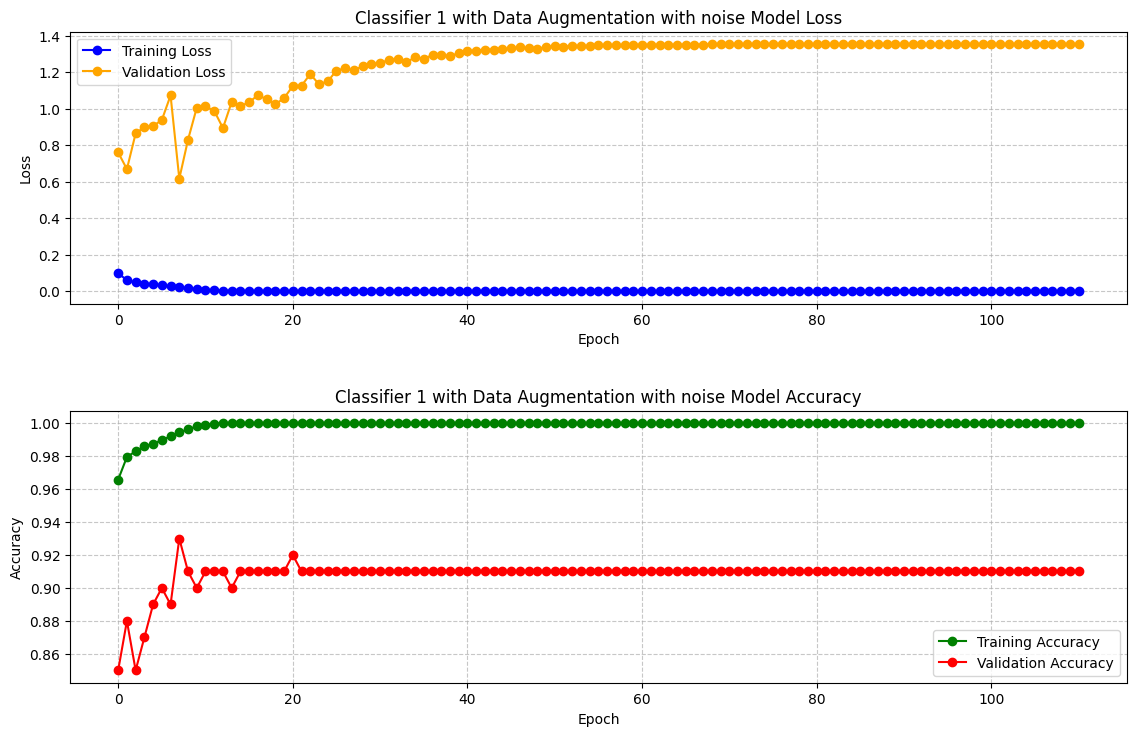

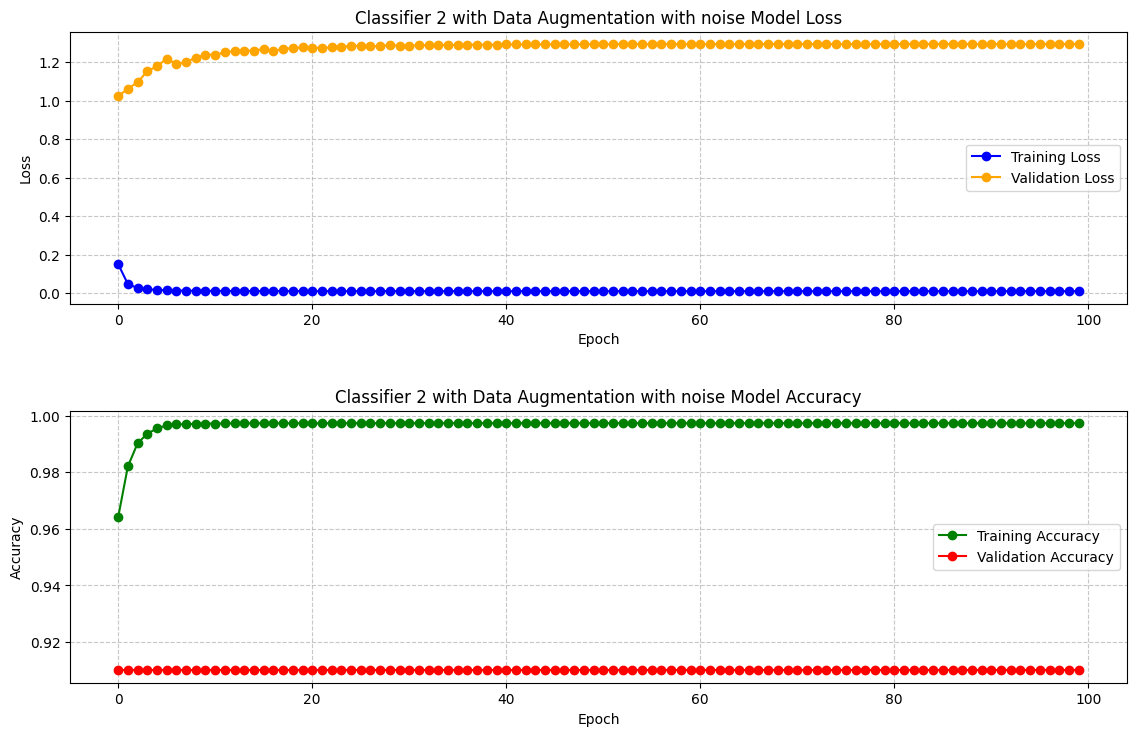

In [ ]:
# Plot the training loss and validation accuracy for each classifier
plot_metrics(history_classifier1_augmented_with_noise, 'Classifier 1 with Data Augmentation with noise')
plot_metrics(history_classifier2_augmented_with_noise, 'Classifier 2 with Data Augmentation with noise')

313/313 [==============================] - 1s 2ms/step


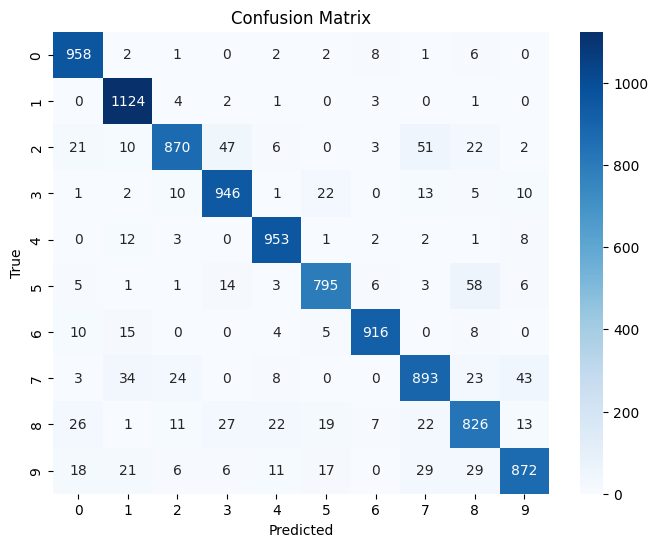

Test Accuracy: 0.9153
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95       980
           1       0.92      0.99      0.95      1135
           2       0.94      0.84      0.89      1032
           3       0.91      0.94      0.92      1010
           4       0.94      0.97      0.96       982
           5       0.92      0.89      0.91       892
           6       0.97      0.96      0.96       958
           7       0.88      0.87      0.87      1028
           8       0.84      0.85      0.85       974
           9       0.91      0.86      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.92      0.91     10000



In [ ]:
# Predictions on the test set using classifier2
y_pred_augmented_with_noise = np.argmax(classifier2_augmented_with_noise.predict(x_test), axis=1)

# Use the function to plot and print metrics
plot_and_print_classification_metrics(y_test, y_pred_augmented_with_noise)

#### Testing the Model on an MNIST Image

1/1 [==============================] - 0s 19ms/step


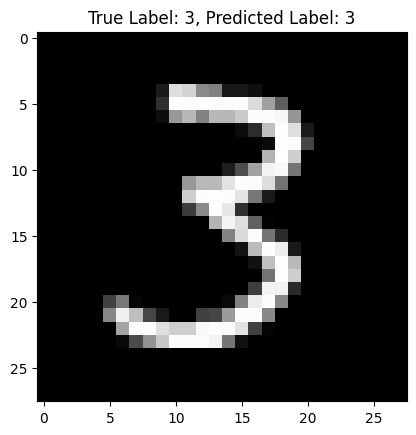

1/1 [==============================] - 0s 19ms/step


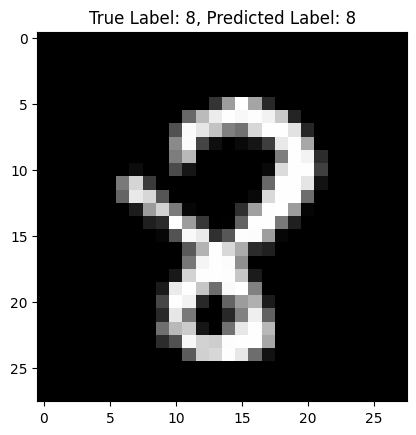

1/1 [==============================] - 0s 19ms/step


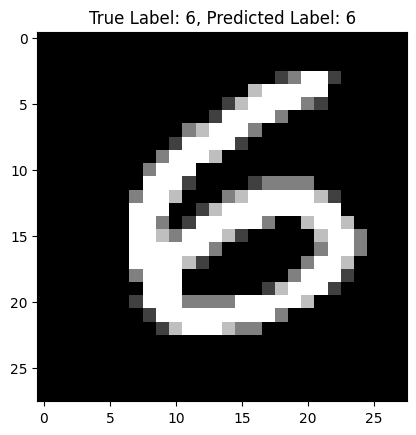

1/1 [==============================] - 0s 21ms/step


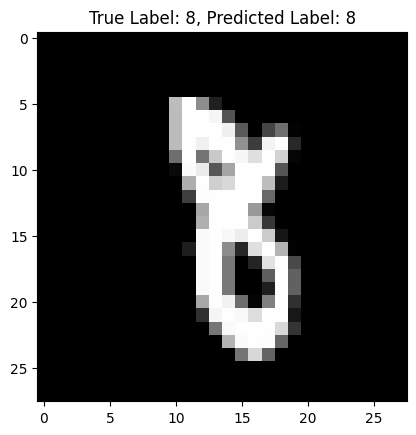

1/1 [==============================] - 0s 18ms/step


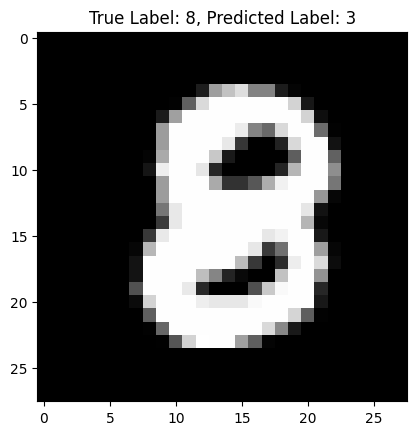

In [ ]:
num_samples = 5
visualize_predictions(classifier2_augmented_with_noise, x_test, y_test, num_samples)